<a href="https://colab.research.google.com/github/galacticor/learndatascience/blob/master/mlforbattery/MLforbattery1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

In [12]:
data = pd.read_csv("https://raw.githubusercontent.com/galacticor/learndatascience/master/mlforbattery/preproccess.xlsx%20-%20Test1.csv")

The imported data was processed in local machine with special method that called "Walk-Forward validation". We are dealing with time series data that need past data to predict the future, not otherwise. So Cross-Validation and Train-test split cant be used. I used the past cycle to predict next cycle.

[data cycle n-1] --> [predict] -->
[result cycle n] --> [data cycle n] -->
[predict] --> [result cycle n+1]

ref = https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

  Cycle discharge  discharge_b  diameter
0     2  277.3889     177.8056      12.0
1     3  317.3194     277.3889      12.0
2     4  354.3333     317.3194      12.0
3     5  368.6806     354.3333      12.0
4     6  369.0556     368.6806      12.0


(654, 4)

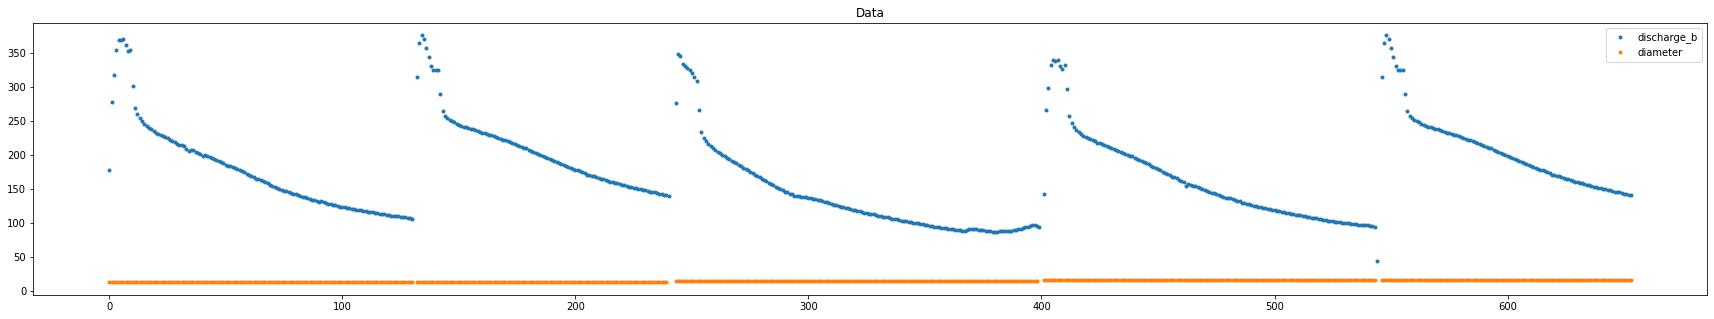

In [13]:
# data = data.drop(labels=['Cycle'], axis=1)
y = data.discharge
print(data.head())
_ = data.plot(style='.', figsize=(30,5), title='Data')
data.describe()
data.shape

In [14]:
data = data.dropna()
data.rename(columns={'discharge' : 'target'}, inplace=True)
print(data.head())
data['target'] = data['target'].astype(float)
data['Cycle'] = data['Cycle'].astype(int)
data['diameter'] = data['diameter'].astype(int)
data.dtypes

  Cycle    target  discharge_b  diameter
0     2  277.3889     177.8056      12.0
1     3  317.3194     277.3889      12.0
2     4  354.3333     317.3194      12.0
3     5  368.6806     354.3333      12.0
4     6  369.0556     368.6806      12.0


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

Cycle            int64
target         float64
discharge_b    float64
diameter         int64
dtype: object

I use the data with diameter = 16 for testing the model and other diameter for training the model

In [15]:
# Use only diameter = 16 for testing and other for training
data_train = data.loc[data.diameter != 16].copy()
data_test = data.loc[data.diameter == 16].copy()

# Drop the target from both training and testing data
y_train = data_train.target
y_test = data_test.target
data_test.drop(labels=['target'], axis=1, inplace=True)
data_train.drop(labels=['target'], axis=1, inplace=True)
data_train.head()
print(data)

     Cycle    target  discharge_b  diameter
0        2  277.3889     177.8056        12
1        3  317.3194     277.3889        12
2        4  354.3333     317.3194        12
3        5  368.6806     354.3333        12
4        6  369.0556     368.6806        12
..     ...       ...          ...       ...
649    105  142.9167     143.6667        16
650    106  142.0000     142.9167        16
651    107  141.0833     142.0000        16
652    108  140.2500     141.0833        16
653    109  139.1667     140.2500        16

[646 rows x 4 columns]


In [16]:
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

# I use XGBoost model
model = XGBRegressor(n_estimators=4000, learning_rate=0.01)
# model = RandomForestRegressor(n_estimators=2500)
model.fit(data_train, y_train)
# y_predict = model.predict(data_test)

[14:05:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=4000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [17]:
# Lets write function that can be used multiple times, this function use last data to predict next data
def tebak(d, datax, cycle):
  check = pd.DataFrame({'Cycle' : [2],'discharge_b':datax['discharge_b'].iloc[0], 'diameter':[d]})
  for i in range(cycle-1):
    res = model.predict(check.tail(1))
    tmp = pd.DataFrame({'Cycle' : check.iloc[-1,0]+1,'discharge_b':res, 'diameter':[d]})
    check=check.append(tmp, ignore_index=True)  
  return check

In [18]:
check = tebak(16,data_test,data_test.shape[0])
check = check.drop(check.index[0]).reset_index(drop=True)
y_check = y_test[:-1]
# print(check.head())
# print(y_check.head())
mae = mean_absolute_error(y_check, check['discharge_b'])
print(mae)
# My model get Mean Absolute Error 16.08, I already tuned the model with various learning rate and n_estimators
# But this score the best XGBoost can get

16.08430688385295


12 5.055843924091046 AxesSubplot(0.125,0.125;0.775x0.755)
13 6.646338081830462 AxesSubplot(0.125,0.125;0.775x0.755)
14 3.0552384210401966 AxesSubplot(0.125,0.125;0.775x0.755)
15 8.12571152206206 AxesSubplot(0.125,0.125;0.775x0.755)
16 16.08430688385295 AxesSubplot(0.125,0.125;0.775x0.755)


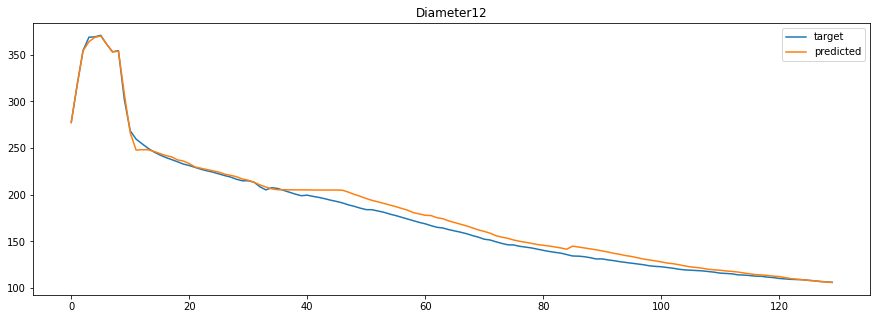

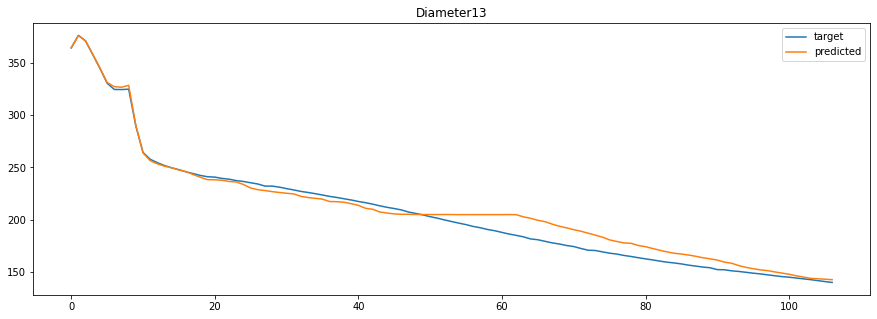

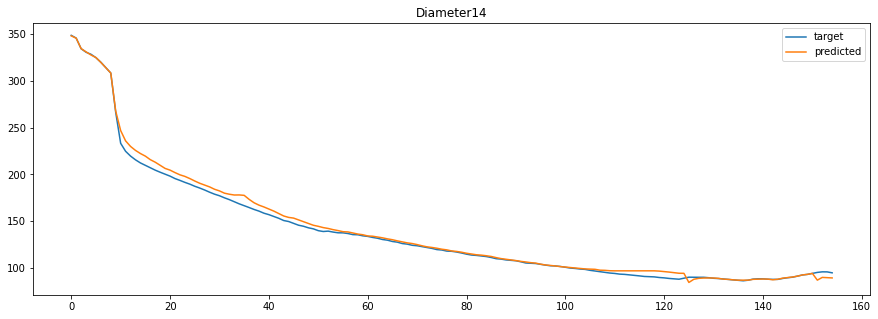

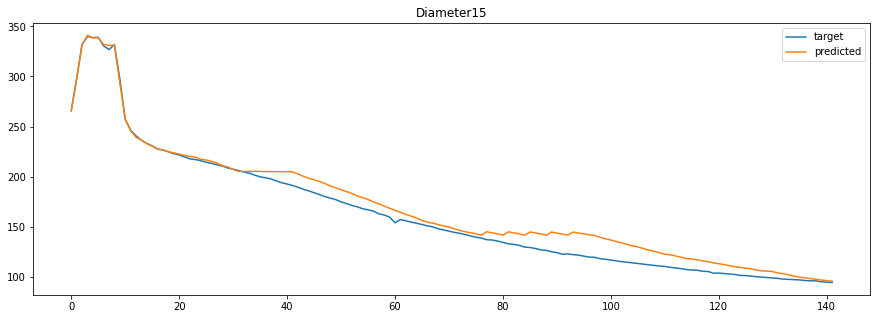

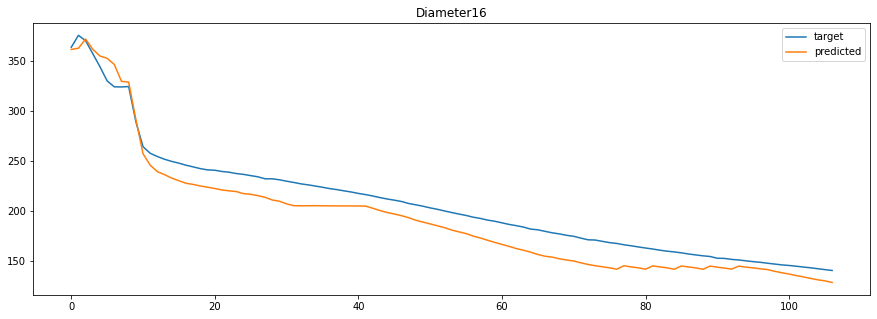

In [19]:
xxx = list()
test = [12,13,14,15,16]
for i in range(len(test)):
  datax = data.loc[data.diameter == test[i]].copy().reset_index(drop=True)
  check = tebak(test[i],datax, datax.shape[0])
  check = check.drop(check.index[0]).reset_index(drop=True)
  datax.drop(datax.tail(1).index, inplace=True)
  # print(check.shape, datax.shape)
  datax['predicted'] = check['discharge_b']
  # print(datax.head)
  xxx.append((datax, test[i]))
  mae = mean_absolute_error(datax['target'],datax['predicted'])
  frame = datax[['target', 'predicted']].plot(figsize=(15, 5), title='Diameter' + str(test[i]))
  print(test[i],mae,frame)
  

After we predict the whole data, we see that the scatter of data target against prediction. 

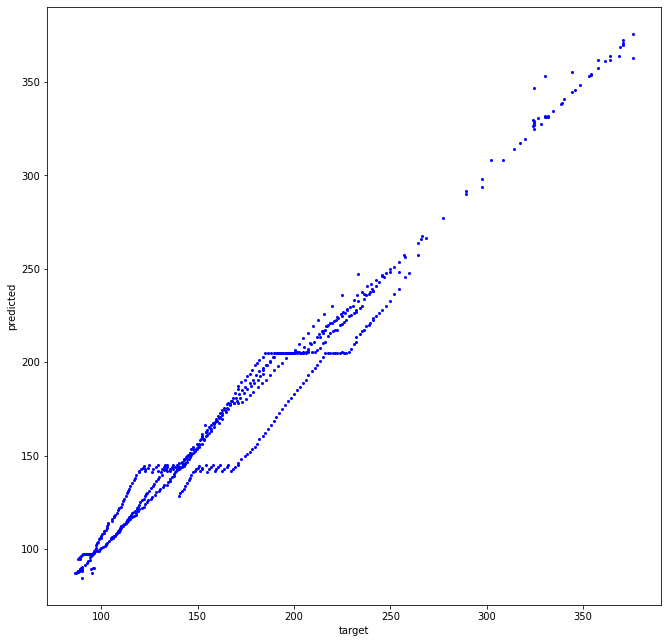

In [20]:
res = pd.concat([x[0] for x in xxx])
plt.figure(figsize=(11,11))
plt.xlabel('target')
plt.ylabel('predicted')
plt.scatter(res['target'], res['predicted'],s=4, c='b', marker='o')
plt.show()

AxesSubplot(0.125,0.125;0.775x0.755)


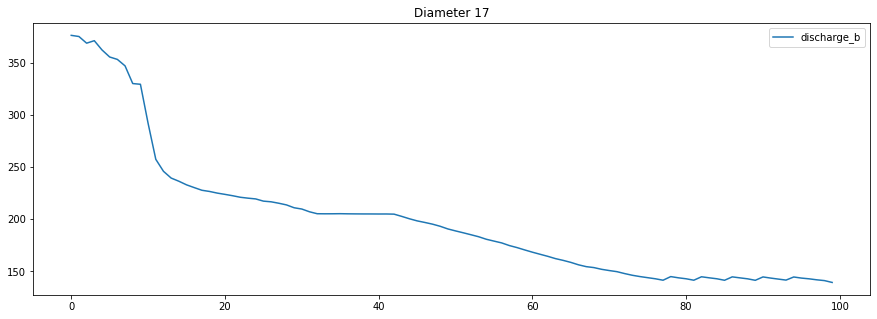

In [21]:
data17 = pd.DataFrame({'Cycle' : [2],'target':376,'discharge_b':376, 'diameter':[17]})
ans17 = tebak(17,data17, 100)
# print(ans17)
data17['predicted'] = ans17['discharge_b']
frame = ans17[['discharge_b']].plot(figsize=(15, 5), title='Diameter ' + str(17))
print(frame)

In [22]:
data.head()

,Cycle,target,discharge_b,diameter
0,2,277.3889,177.8056,12
1,3,317.3194,277.3889,12
2,4,354.3333,317.3194,12
3,5,368.6806,354.3333,12
4,6,369.0556,368.6806,12


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


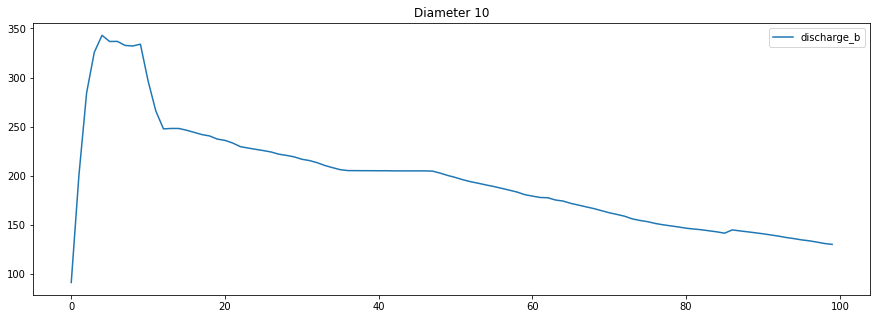

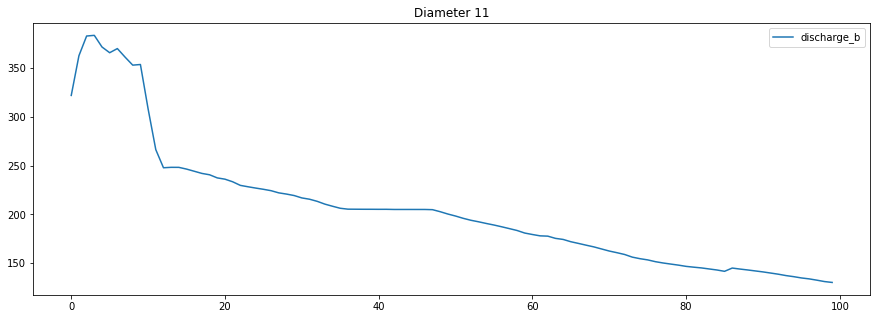

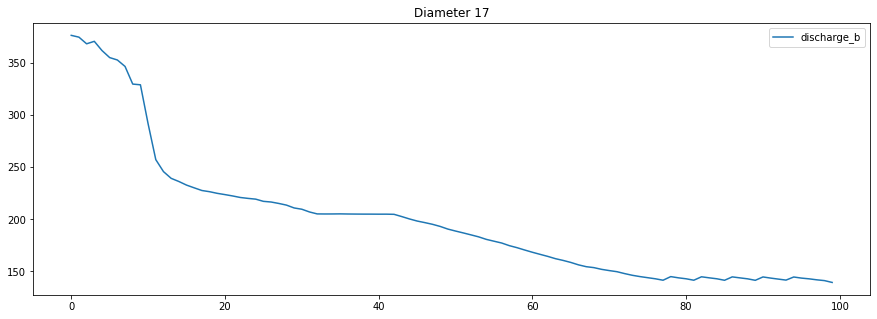

In [23]:
test2 = [(10, 91.4306), (11,321.9167), (17,376.625)]
result = []
for x in test2:
  datax = pd.DataFrame({'Cycle' : [2],'target':x[1],'discharge_b':x[1], 'diameter':x[0]})
  check = tebak(x[0], datax, 100)
  frame = check[['discharge_b']].plot(figsize=(15, 5), title='Diameter ' + str(x[0]))
  print(frame)
  result.append(check)

In [24]:
from google.colab import files
final = pd.DataFrame()

for i in range (len(result)):
  result[i].to_csv('data{}.csv'.format(i))
  final[str(result[i]['diameter'].iloc[0])] = result[i]['discharge_b']

for i in range(len(xxx)):
  xxx[i][0].to_csv('data{}.csv'.format(xxx[i][1]))
  final[str(xxx[i][0]['diameter'].iloc[0])] = xxx[i][0]['predicted']
  



In [25]:
print(result[1].head())
print(xxx[1][0].head())
print(final.head())

   Cycle  discharge_b  diameter
0      2   321.916700        11
1      3   362.635254        11
2      4   382.822968        11
3      5   383.508850        11
4      6   371.584320        11
   Cycle    target  discharge_b  diameter   predicted
0      2  364.0000     314.3333        13  364.195343
1      3  375.9861     364.0000        13  375.704559
2      4  370.6389     375.9861        13  370.653687
3      5  357.6111     370.6389        13  357.730865
4      6  344.5139     357.6111        13  344.803741
           10          11          17  ...          14          15          16
0   91.430600  321.916700  376.625000  ...  348.144867  265.757324  361.896088
1  200.632278  362.635254  374.894867  ...  345.628845  297.801086  363.072876
2  284.472137  382.822968  368.509247  ...  334.501709  331.644867  372.292908
3  325.726654  383.508850  370.884491  ...  331.018494  340.983765  362.035217
4  342.971527  371.584320  362.035217  ...  327.679291  338.432556  355.272156

[5 rows x

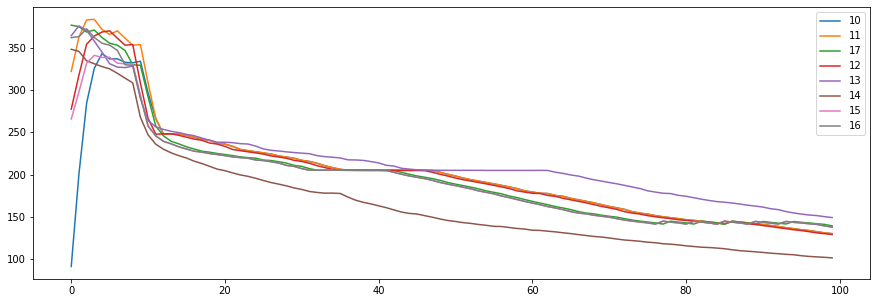

In [26]:
frame = final.plot(figsize=(15,5))

Input data buat test, diameter 10 11 17

11.934237299148174 AxesSubplot(0.125,0.125;0.775x0.755)
15.680529072108838 AxesSubplot(0.125,0.125;0.775x0.755)
18.530621192578128 AxesSubplot(0.125,0.125;0.775x0.755)


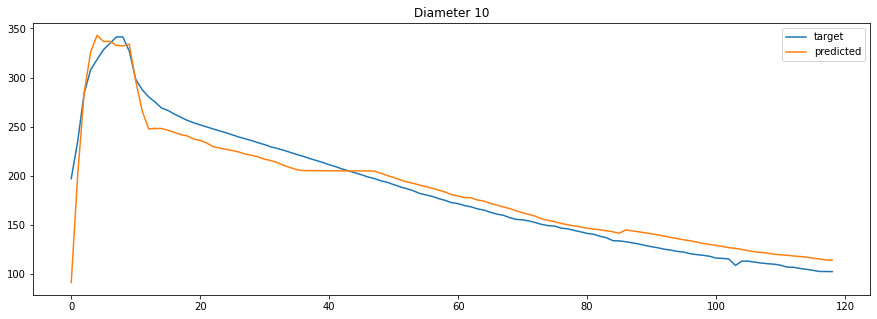

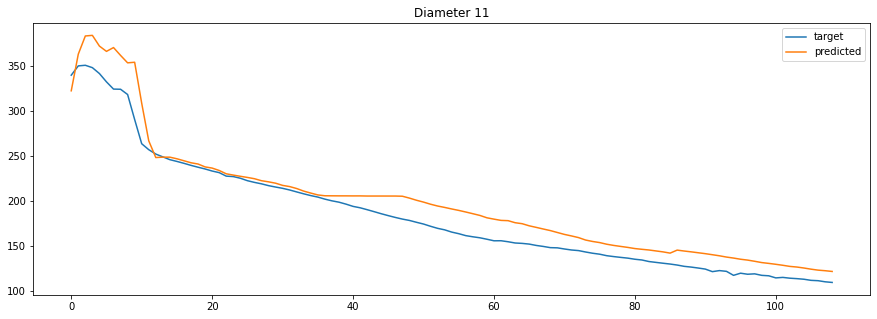

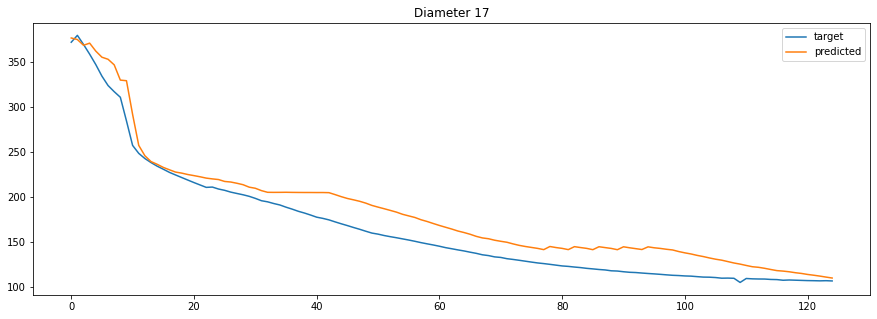

In [27]:
data2 = pd.read_csv("https://raw.githubusercontent.com/galacticor/learndatascience/master/mlforbattery/preproccess.xlsx%20-%20Test2.csv")
test2 = [10,11,17]
# print(data2.dtypes, data.head(), data2.head())
xdata = []
for i in range(len(test2)):
  datax = data2.loc[data2.diameter == test2[i]].copy().reset_index()
  check = tebak(test2[i],datax, datax.shape[0])
  datax['predicted'] = check['discharge_b']
  xdata.append((datax, test2[i]))
  mae = mean_absolute_error(datax['target'],datax['predicted'])
  frame = datax[['target', 'predicted']].plot(figsize=(15, 5), title='Diameter ' + str(test2[i]))
  print(mae,frame)